<a href="https://www.kaggle.com/code/mldaniella/predicting-apartment-prices-in-seoul?scriptVersionId=281770428" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# Predicting apartment prices in Seoul

Mi Lim Kim - Jun 2025


# Default setting

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seoul-apt-prices-20062012/APT_price_seoul_2006_2012.csv


# Outline

We will follow those steps to predict house prices of the apartments in Seoul.


1. Program Setting and Data Loading
2. Preprocessing features 
 > * numeric & categorical variables (imputation & encoding)
 > * adding new features & regularization
3. Implementation of models and algorithms
4. Fitting, prediction and evaluation

# Background

Real estate prices have long been at the center of government policy discussions, as they are closely connected to the current and future lives of all individuals. In South Korea, the sharp movement in housing prices is closely intertwined with broader social issues, including the declining birth rate. Accurately anticipating changes in real estate prices is therefore crucial, enabling policymakers to respond proactively and design effective interventions.

# Questions

The questions we want to answer through this analysis are as follows:

1. Which machine is the best model to predict apartment prices in Seoul? 
2. What is the set of characteristics (features) related to the apartments that should be considered to predict house prices effectively?


# Packages used

First, we load some packages by executing the lines below to make an environment for this analysis.

In [2]:
# graphs
!pip install seaborn -U
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings

# stats
from scipy.stats import skew, pearsonr, norm, probplot
from scipy import stats
from collections import Counter


# XGBoost / LightGBM
from xgboost import XGBRegressor
import lightgbm as lgb

# SVM
from sklearn.svm import SVC, SVR
from sklearn import svm

# Linear / Regularized Models
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LassoCV,
    Ridge,
    LassoLarsCV,
    ElasticNetCV,
    ElasticNet
)

# Model Selection / CV
from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
    learning_curve,
    train_test_split
)


from sklearn.feature_selection import SelectFromModel

# Ensemble Models
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor
)

# Neighbors / Neural Nets
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor

from sklearn.neural_network import MLPClassifier, MLPRegressor

# Preprocessing & Imputation
from sklearn.preprocessing import (
    StandardScaler,
    Normalizer,
    RobustScaler,
    OneHotEncoder
)
from sklearn.impute import SimpleImputer

# Metrics
from sklearn.metrics import (
    mean_absolute_error,
    balanced_accuracy_score,
    roc_auc_score,
    make_scorer,
    confusion_matrix,
    plot_confusion_matrix,
    precision_score,
    accuracy_score,
    r2_score
)
from sklearn.metrics.pairwise import rbf_kernel

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline



Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.10.0)


# Data loading



We use apartment sale prices of Seoul registered in 2012.

The features of apartments can be categorized with severeal levels.
- Individual apartment level feature (e.g. size, floor)
- APT complex level feature (e.g. construction year, number of apartments per complex)
- District (borough) level feature (e.g. school quality)




In [3]:
# Loading the data set
apt_price=pd.read_csv("../input/seoul-apt-prices-20062012/APT_price_seoul_2006_2012.csv")

# change the unit of price from Won (in 10k won) to Dollar
apt_price["price"] = apt_price["price"]*10

# check the apt_price
apt_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347436 entries, 0 to 347435
Data columns (total 52 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   BuildId           347436 non-null  object 
 1   year              347436 non-null  int64  
 2   lon               347436 non-null  float64
 3   lat               347436 non-null  float64
 4   midschoolDist     347436 non-null  object 
 5   a                 347436 non-null  float64
 6   District          347436 non-null  int64  
 7   dangiCode         347436 non-null  int64  
 8   subDist           347436 non-null  int64  
 9   key               347436 non-null  int64  
 10  V1                347436 non-null  int64  
 11  name              347436 non-null  object 
 12  maxBuild          347372 non-null  float64
 13  maxFloor          347372 non-null  float64
 14  built_date        347372 non-null  object 
 15  Hhld              347372 non-null  float64
 16  renters           20

# Features used

* We select the features ('features_selected') and the target variable ('y').

* Target variable **'y'**: apartment transaction price in 2012.
* Variables **'features_slected'** and explanations on those variables are as follows:

> 1. `BuildId`: identifier for the apartment complex to which the unit belongs.  
> 2. `District`: district (borough) in which the apartment or apartment complex is located.  
> 3. `maxBuild`: number of apartment buildings within the complex. In South Korea, larger apartment complexes tend to be more valued because amenity-related costs can be shared across more households, reducing individual financial burdens and facilitating the development of additional facilities.  
> 4. `Built_year`: year in which the apartment complex was constructed.  
> 5. `Hhld`: number of households residing in the apartment complex.  
> 6. `yearmon`: year and month when the apartment unit was sold.  
> 7. `Floor`: floor level of the apartment unit.  
> 8. `Size`: floor area of the apartment unit.  
> 9. `dong`: subdistrict in which the apartment is located.  
> 10. `schoolDistHS`: name of the high school district in which the apartment is located.  
> 11. `new..prop..snu23`: indicator representing the quality of the school district.  
> 12. `Age_complex`: age of the apartment complex to which the unit belongs.  

* We can see that some features represent the same (or similar) characteristics of the apartments (e.g. 'Age_complex' and 'Built_year'). We deal with this problem in a later part of this analysis.


# Making sets of data for training, testing, and validating models

In [4]:
# Set of features to be used 
features_selected = ['District', 'maxBuild', 'Hhld', 'Floor', 'Size', 'schoolDistHs', 'new..prop..snu23', 'Age_complex', 'yearmon', 'BuildId']

def select_dat_specific_year(yr, fraction=None):
    # Select data of the APTs that were sold in yr
    if fraction is None:
        apt_price12 = apt_price[apt_price['year'] == yr]
    else:
        apt_price12 = apt_price[apt_price['year'] == yr]
        apt_price12 = apt_price12.sample(frac=fraction)

    # Remove rows with missing target, separate target from predictors
    X_full = apt_price12.dropna(axis=0, subset=['price'])

    X = X_full[features_selected]
    X.rename(columns = {'new..prop..snu23': 'schoolQuality'}, inplace= True)
    y = X_full['price']
    
    return X, y


# Make train/validation data set
X, y = select_dat_specific_year(yr=2012)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, 
                                                                train_size = 0.8, test_size=0.2,
                                                                random_state=42)


# Select categorical columns with dtype=object that will be encoded in a later part
categorical_cols0 = [cname for cname in X_train_full.columns if 
                    X_train_full[cname].dtype == "object"]
categorical_cols = list(set(categorical_cols0) - set(['yearmon', 'BuildId']))

# Select numerical columns that will be imputed in a later part
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]


# Keep selected columns only (categorical & numerical columns)
my_cols = categorical_cols0 + numerical_cols

X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

# Making test data set (we use 10% of 2011 data as test data)

X_test_full, y_test_full = select_dat_specific_year(yr = 2011, fraction=0.1)
X_test = X_test_full[my_cols].copy()
y_test = y_test_full.copy()

# Preprocessing of features

## Imputation of numeric variables

We impute missing values using the mean of each numerical column.

In [5]:
# Verify the number of missing values for each numeric variable
missing_val_count_by_column = X_train.isnull().sum()
print(missing_val_count_by_column[missing_val_count_by_column > 0])

# Fill in the lines below: imputation

# Imputation for numerical_cols and train/validation/test data sets
my_imputer = SimpleImputer(strategy="mean") 
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train[numerical_cols]), 
                               columns=numerical_cols,
                              index=X_train.index)
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid[numerical_cols]),
                              columns=numerical_cols,
                              index=X_valid.index)
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test[numerical_cols]),
                             columns=numerical_cols,
                             index=X_test.index)


maxBuild       5
Hhld           5
Age_complex    5
dtype: int64


## Encoding categorical variables

* We encode the categorical variables using the one-hot encoding way.
* Then, we combine encoded categorical variables with numeric variables.


In [6]:
# condition
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# do one-hot encode the categorical_cols
OH_encoder.fit(X_train[categorical_cols])

# Column names from encoder
OH_cols = OH_encoder.get_feature_names(categorical_cols)

# Transform
OH_X_train0 = pd.DataFrame(OH_encoder.transform(X_train[categorical_cols]),
                           columns=OH_cols,
                           index=X_train.index)

OH_X_valid0 = pd.DataFrame(OH_encoder.transform(X_valid[categorical_cols]),
                           columns=OH_cols,
                           index=X_valid.index)

OH_X_test0 = pd.DataFrame(OH_encoder.transform(X_test[categorical_cols]),
                          columns=OH_cols,
                          index=X_test.index)

# combine encoded categorical_cols with numeric variables + rest of variables ('BuildId', 'yearmon')
OH_X_train = pd.concat([imputed_X_train, OH_X_train0, X_train[['BuildId','yearmon']]], axis=1)
OH_X_valid = pd.concat([imputed_X_valid, OH_X_valid0, X_valid[['BuildId','yearmon']]], axis=1)
OH_X_test = pd.concat([imputed_X_test, OH_X_test0, X_test[['BuildId','yearmon']]], axis=1)

In [7]:
# check the final results
OH_X_train.describe()

,District,maxBuild,Hhld,Floor,Size,schoolQuality,Age_complex,schoolDistHs_Bukbu,schoolDistHs_Dong Jak,schoolDistHs_Dongbu,schoolDistHs_Gang Dong,schoolDistHs_Gang Nam,schoolDistHs_Gang Seo,schoolDistHs_Joongbu,schoolDistHs_Nambu,schoolDistHs_Seobu,schoolDistHs_Seongbuk,schoolDistHs_Seongdong
count,2.577900e+04,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000,25779.000000
mean,1.146912e+09,14.370684,1205.384496,9.059234,77.220526,0.892609,15.403042,0.170332,0.069204,0.070057,0.146941,0.110206,0.091159,0.034835,0.106676,0.083828,0.072268,0.044494
std,1.775235e+07,19.796759,1335.076785,6.028544,28.750059,0.684364,8.864497,0.375932,0.253805,0.255248,0.354054,0.313152,0.287841,0.183364,0.308707,0.277135,0.258936,0.206193
min,1.111000e+09,1.000000,11.000000,-1.000000,14.380000,0.289610,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.132000e+09,4.000000,322.000000,4.000000,59.610000,0.491833,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.147000e+09,8.000000,736.000000,8.000000,82.610000,0.693246,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.165000e+09,16.000000,1597.000000,13.000000,84.960000,1.012897,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.174000e+09,134.000000,6864.000000,57.000000,271.450000,3.739680,45.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Add more features and/or selecting the optimal set of features

* We can add more features by transforming the existing features and/or limit the number of features to be used for training machines to improve the performances (reducing over-fitting problem).
* We introduce a manual approach for engineering additional features and an automated method for selecting an optimal set of features.
* More specifically, we include an automated feature selection method using an L1‐regularized logistic regression model combined with SelectFromModel (sklearn). This approach automatically discards features with negligible importance by shrinking their coefficients to zero.

## Add the second power of size to capture the nonlinearity of the effect of size on house prices.

In [8]:
# Add the second power of size to capture the nonlinearity of the effect of size on house prices.

def second_power(series):
    # series is changed to numpy array.
    
    tmp=np.array(series)
    tmp2=tmp**2
    
    # the new series is changed to panda series.
    
    tmp3=pd.Series(tmp2, index = series.index)
    
    return tmp3

# Apply the fct defined above.

OH_X_train['Size2']=second_power(OH_X_train['Size'])
OH_X_valid['Size2']=second_power(OH_X_valid['Size'])
OH_X_test['Size2']=second_power(OH_X_test['Size'])


# Verify if there is missing values in the new series

print(OH_X_train['Size2'].isnull().sum())
print(OH_X_valid['Size2'].isnull().sum())
print(OH_X_test['Size2'].isnull().sum())

0
0
0


## Add the number of APT sales of the month happened by APT complex


In [9]:

def add_monthly_sales_count(df):
    df = df.copy()
    dt = pd.to_datetime(df['yearmon'])
    df['_sale_month'] = dt.dt.to_period('M')
    df['num_sales_same_month_by_complex'] = (
        df.groupby(['BuildId', '_sale_month'])['_sale_month'].transform('size')
    )
    df.drop(columns=['_sale_month'], inplace=True)
    return df

OH_X_train = add_monthly_sales_count(OH_X_train)
OH_X_valid = add_monthly_sales_count(OH_X_valid)
OH_X_test  = add_monthly_sales_count(OH_X_test)

# drop 'BuildId' and 'yearmon' columns for the next step
OH_X_train.drop(['BuildId', 'yearmon'], axis=1, inplace=True)
OH_X_valid.drop(['BuildId', 'yearmon'], axis=1, inplace=True)
OH_X_test.drop(['BuildId', 'yearmon'], axis=1, inplace=True)


In [10]:
OH_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25779 entries, 94269 to 243809
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   District                         25779 non-null  float64
 1   maxBuild                         25779 non-null  float64
 2   Hhld                             25779 non-null  float64
 3   Floor                            25779 non-null  float64
 4   Size                             25779 non-null  float64
 5   schoolQuality                    25779 non-null  float64
 6   Age_complex                      25779 non-null  float64
 7   schoolDistHs_Bukbu               25779 non-null  float64
 8   schoolDistHs_Dong Jak            25779 non-null  float64
 9   schoolDistHs_Dongbu              25779 non-null  float64
 10  schoolDistHs_Gang Dong           25779 non-null  float64
 11  schoolDistHs_Gang Nam            25779 non-null  float64
 12  schoolDistHs_

## [Optional] Select the optimal set of features (using L1 Lasso regression classifier)

We introduce an automated feature selection procedure here; however, this step is not applied in the final model, as the number of columns in our dataset is relatively small.

In [11]:
# We search for the best value of 'K' which is the number of variables that will be used in training
def select_features_l1_regression(X, y):
    """Return selected feature names using L1-regularized regression (Lasso)."""
    
    # L1 Lasso regression as y is continuous column
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1)
    lasso.fit(X, y)
    
    # select features whose coeff are not 0
    model = SelectFromModel(lasso, prefit=True)
    support = model.get_support()              # True/False mask
    selected_cols = X.columns[support]
    return selected_cols


select_col=select_features_l1_regression(OH_X_train, y_train)

X_train_reg=OH_X_train[select_col]
X_valid_reg=OH_X_valid[select_col]
X_test_reg=OH_X_test[select_col]


# combine selected columns + rest of variables ('BuildId', 'yearmon')

#OH_X_train = pd.concat([X_train_reg, X_train[['BuildId', 'yearmon']]], axis=1)
#OH_X_valid = pd.concat([X_valid_reg, X_valid[['BuildId', 'yearmon']]], axis=1)
#OH_X_test = pd.concat([X_test_reg, X_test[['BuildId', 'yearmon']]], axis=1)

#OH_X_train.info()

# Parsing data 

## * Average house prices in 2012
* the average APT price of Seoul is $ 449597 in 2012.


In [12]:
# Description of the APT prices (target variable)
y_train.describe()

count    2.577900e+04
mean     4.503087e+05
std      3.013751e+05
min      6.200000e+04
25%      2.660000e+05
50%      3.700000e+05
75%      5.375000e+05
max      5.499130e+06
Name: price, dtype: float64


 mu = 450308.73 and sigma = 301369.27



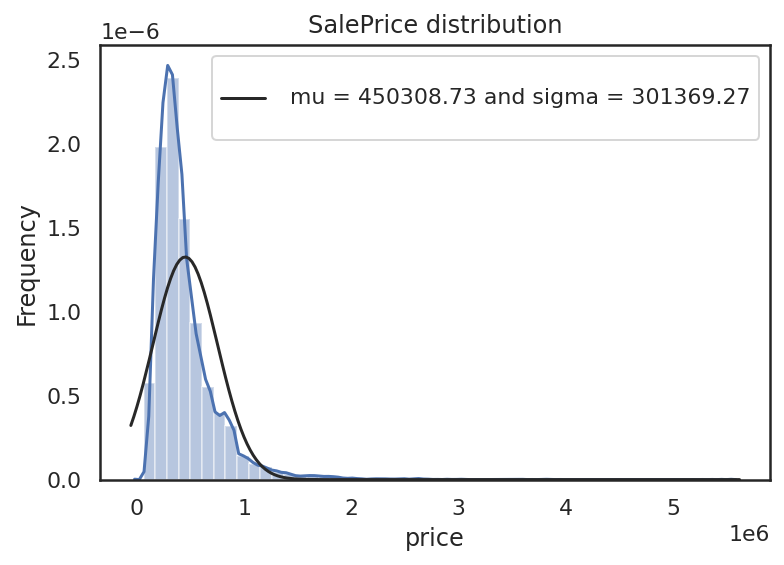

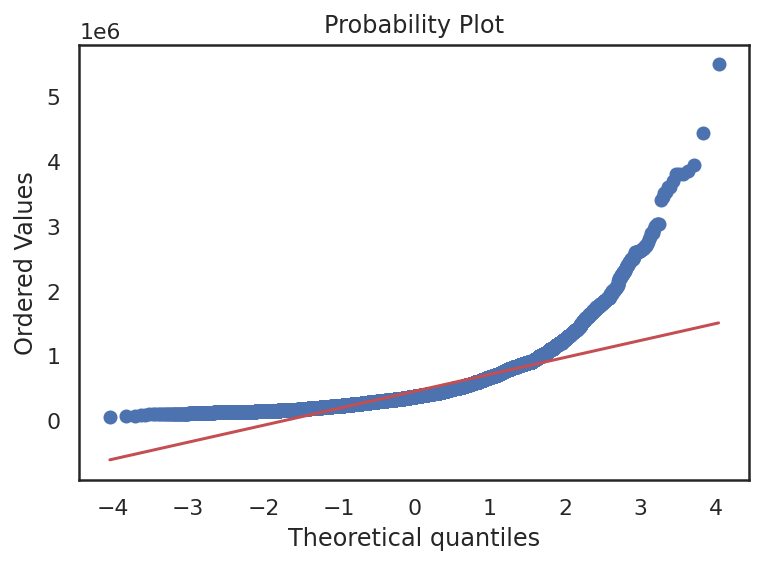

Skewness: 3.151029
Kurtosis: 19.437938


In [13]:
# Plot Histogram
sns.distplot(y_train, fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)

label_text = '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma)
print(label_text)
plt.legend([label_text],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Q-Q plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt())

* Comment: Using raw apartment prices, the distribution clearly deviates from normality.
This is also evident in the quantile–quantile (Q–Q) plot.


 mu = 12.86 and sigma = 0.54



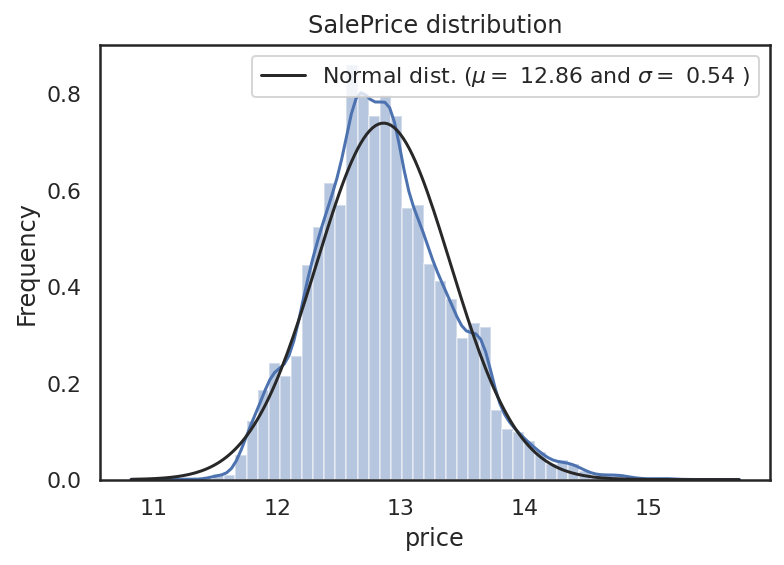

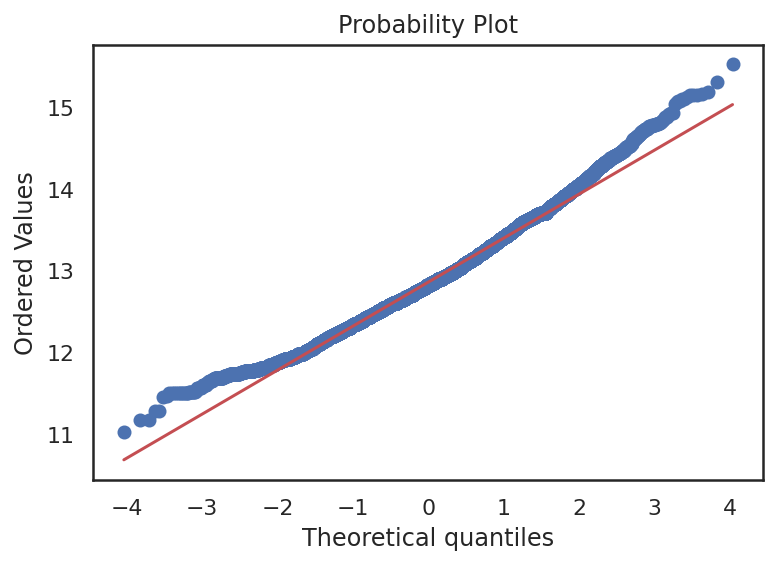

Skewness: 0.417499
Kurtosis: 0.267680


In [14]:
# We do a same analysis using log(price)
logy = np.log(y_train)

# Plot Histogram
sns.distplot(logy, fit=norm)

# Getting the fitted parameters used by the function
(mu, sigma) = norm.fit(logy)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Q-Q plot
fig = plt.figure()
res = stats.probplot(logy, plot=plt)
plt.show()

print("Skewness: %f" % logy.skew())
print("Kurtosis: %f" % logy.kurt())

* Comment:
* Applying a log transformation to apartment prices makes the distribution closer to normal.
* In this analysis, we do not focus on identifying the effects of individual features; rather, our goal is to generate predictions and compare the predictive performance of several models.
* If we wish to assess the statistical significance of features, the assumption that prediction errors follow a normal distribution with mean zero must be satisfied, since confidence intervals and significance tests rely on this assumption.
* As noted earlier, because evaluating feature significance is not the main objective here, we do not correct the non-normality (skewness) of the target variable.
*  If,[](http://)however, we were interested in identifying significant predictors, we would need to build the model, obtain predictions, and then examine the distribution of prediction errors (e.g., via diagnostic plots, [cf](https://towardsdatascience.com/is-normal-distribution-necessary-in-regression-how-to-track-and-fix-it-494105bc50dd)).

## * Average house prices by district.

* We look into a boxplot that represents the summary statistics (min, 1Q, Median, 3Q, max, outliers) of APT prices across districts.

(-0.5, 24.5, 0.0, 3000000.0)

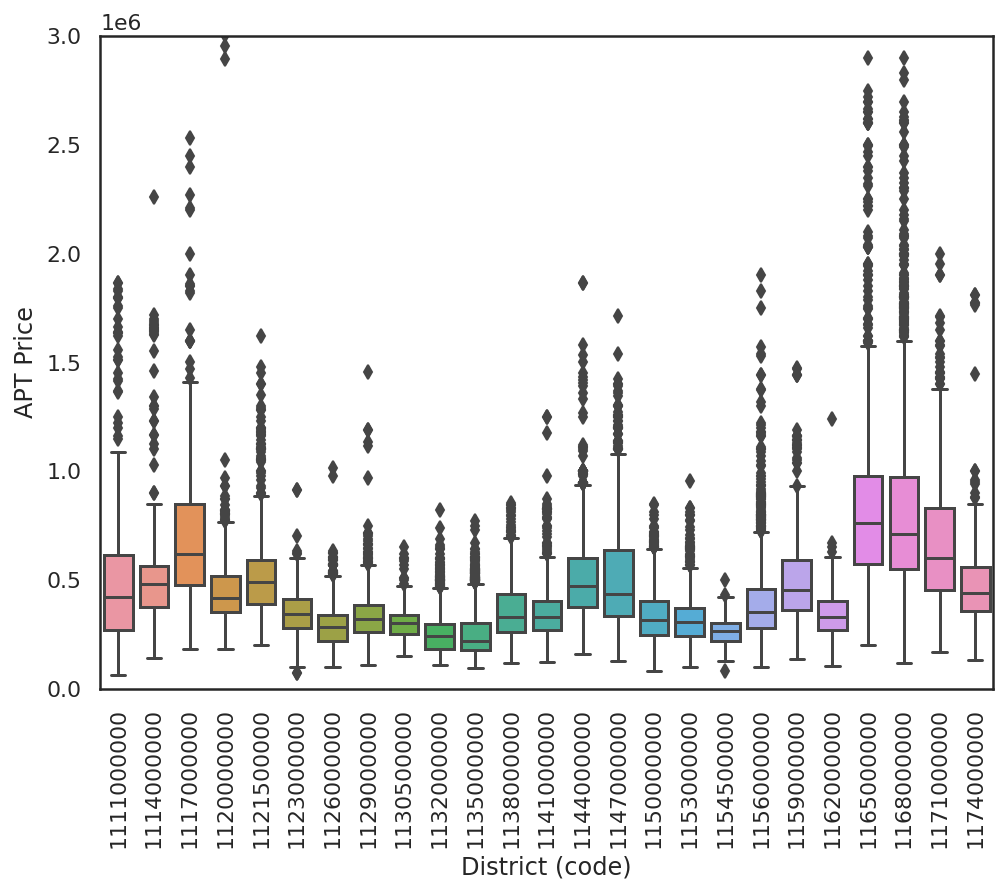

In [15]:
# APT house prices by district

var = 'District'
data = pd.concat([y_train, X_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.set_xlabel('District (code)')
fig.set_ylabel('APT Price')
fig.axis(ymin=0, ymax=3e+6)


* The distribution of apartment prices varies substantially across districts.

## * Average house prices by school district.


(-0.5, 10.5, 0.0, 3000000.0)

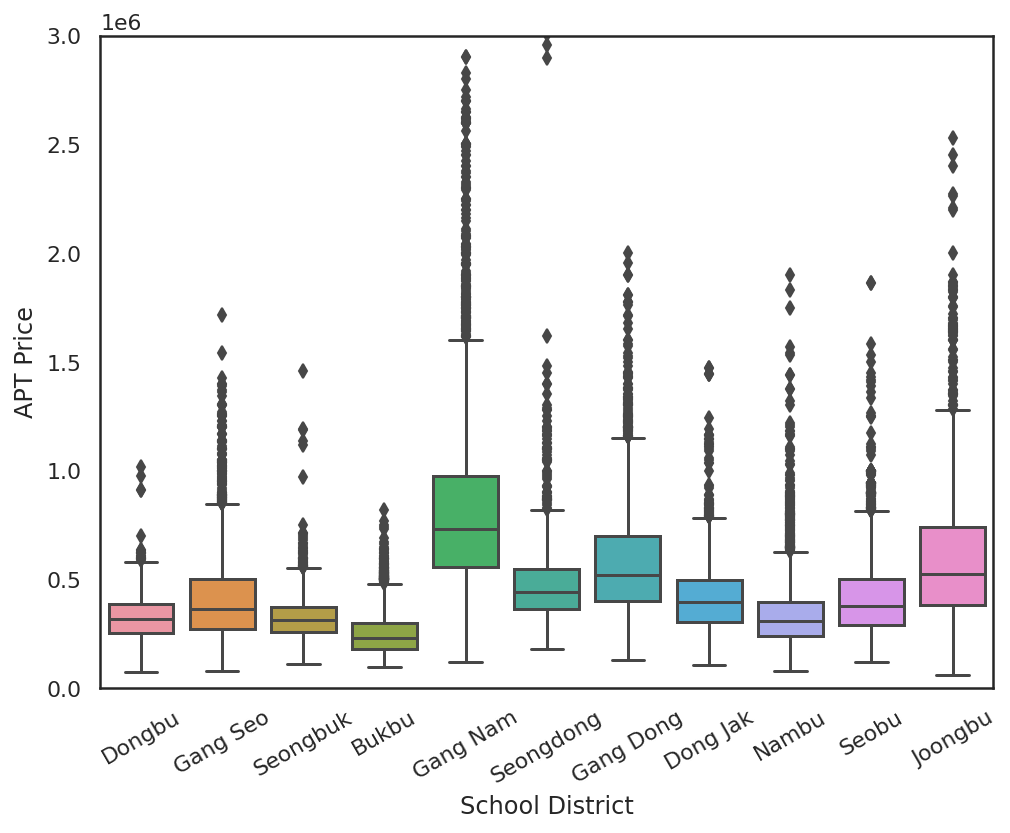

In [16]:
# APT house prices by school district

var = 'schoolDistHs'
data = pd.concat([y_train, X_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6));
fig = sns.boxplot(x=var, y="price", data=data)
fig.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig.set_xlabel('School District')
fig.set_ylabel('APT Price')
fig.axis(ymin=0, ymax=3000000)


* We found that the APT prices across school districts are quite different.
* These variations in prices are due to the variations in the school quality.
> * school quality is measured as the average percentage of students that are accepted to the best university (SNU) of the nearest 3 high schools from the APT.

(-0.5, 10.5, 0.0, 5.0)

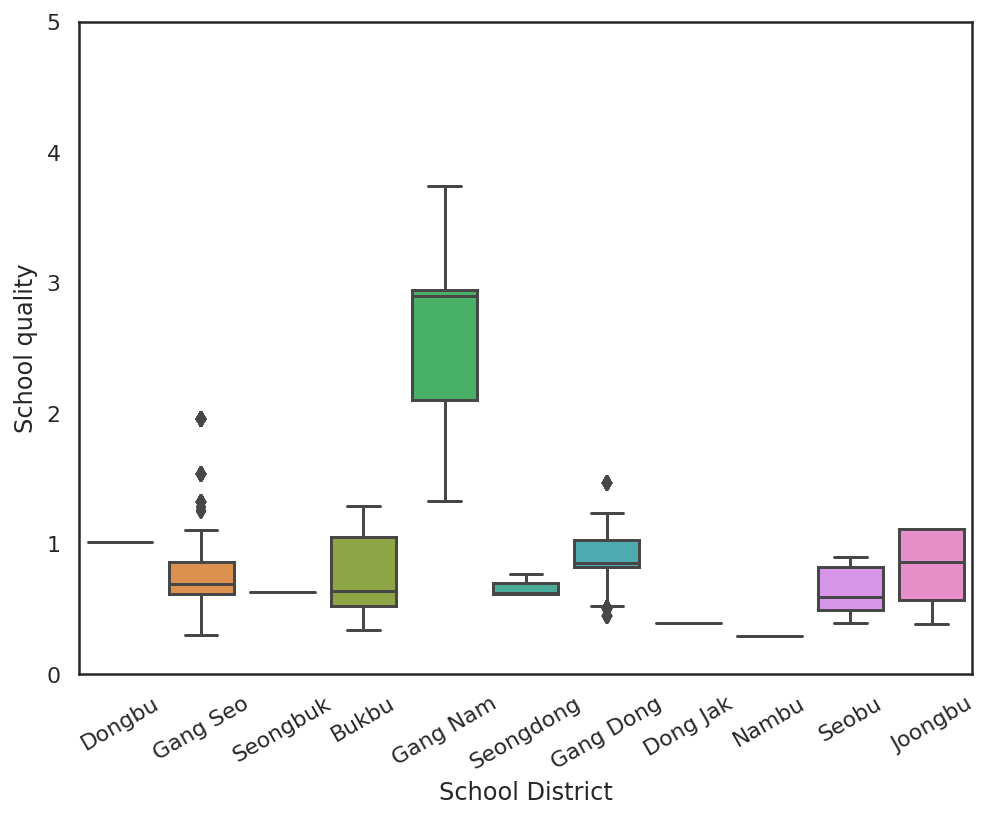

In [17]:
# School quality by school district

var = 'schoolDistHs'
xx = X_train['schoolQuality']
data = pd.concat([xx, X_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6));
fig = sns.boxplot(x='schoolDistHs', y='schoolQuality', data=data)
fig.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig.set_xlabel('School District')
fig.set_ylabel('School quality')
fig.axis(ymin=0, ymax=5)

## * Average house prices across the apt size, the floor, and the number of households.

* For the details on the seaborn graphs (jointplot), see [here](https://seaborn.pydata.org/generated/seaborn.jointplot.html)


Text(23.125, 0.5, 'APT Price')

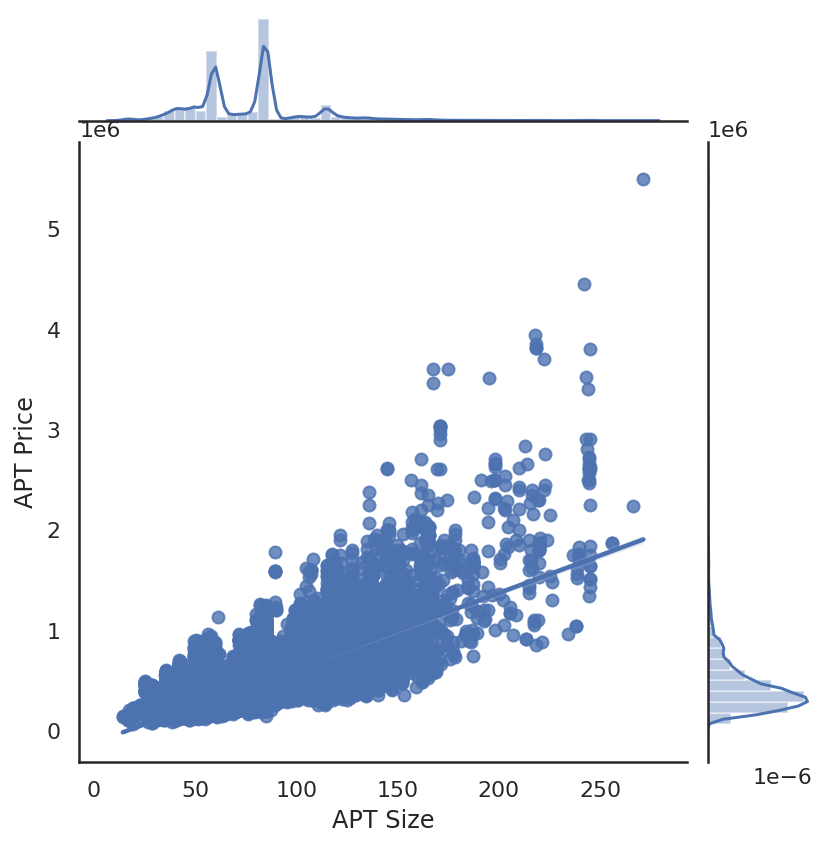

In [18]:
# Apt size vs Sale Price

fig= sns.jointplot(x=X_train['Size'], y= y_train, kind="reg" )
fig.ax_joint.set_xlabel('APT Size')
fig.ax_joint.set_ylabel('APT Price')

Text(23.125, 0.5, 'Price')

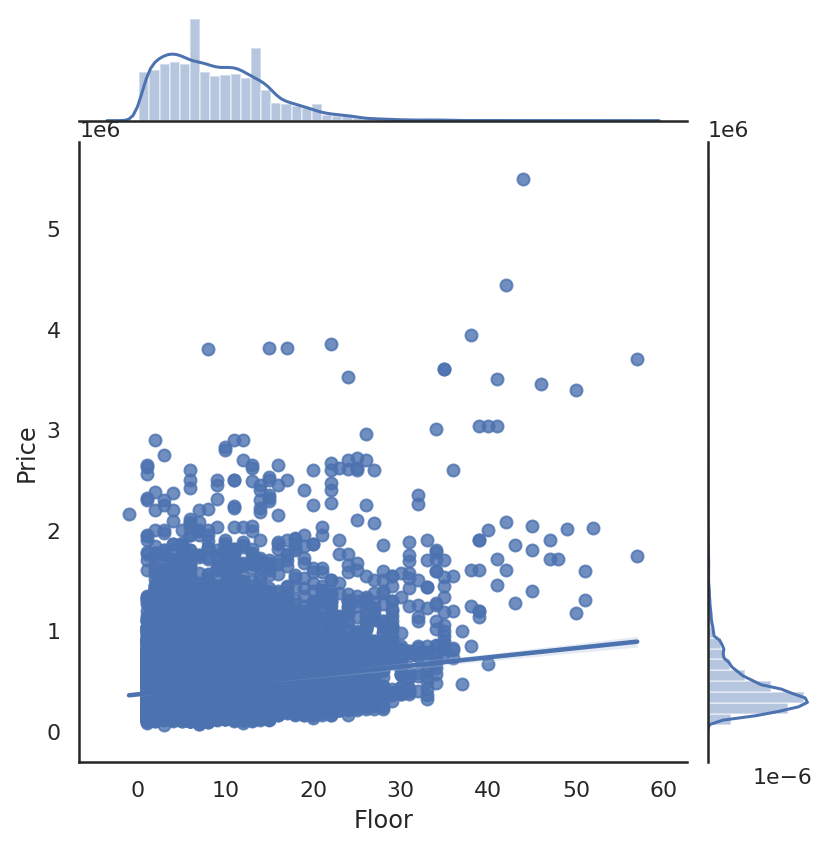

In [19]:
# Apt floor vs Sale Price


fig = sns.jointplot(x=X_train['Floor'], y= y_train, kind='reg')
fig.ax_joint.set_xlabel('Floor')
fig.ax_joint.set_ylabel('Price')

Text(23.125, 0.5, 'Price')

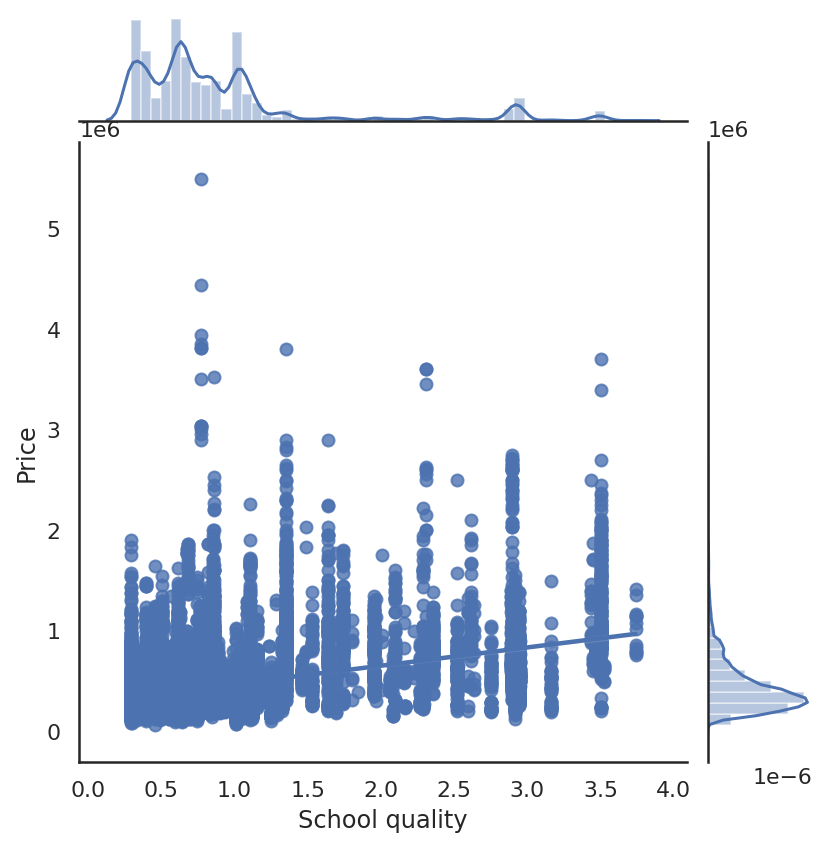

In [20]:
# School quality vs Sale Price

fig = sns.jointplot(x=X_train['schoolQuality'], y= y_train, kind='reg')
fig.ax_joint.set_xlabel('School quality')
fig.ax_joint.set_ylabel('Price')

Text(23.125, 0.5, 'Price')

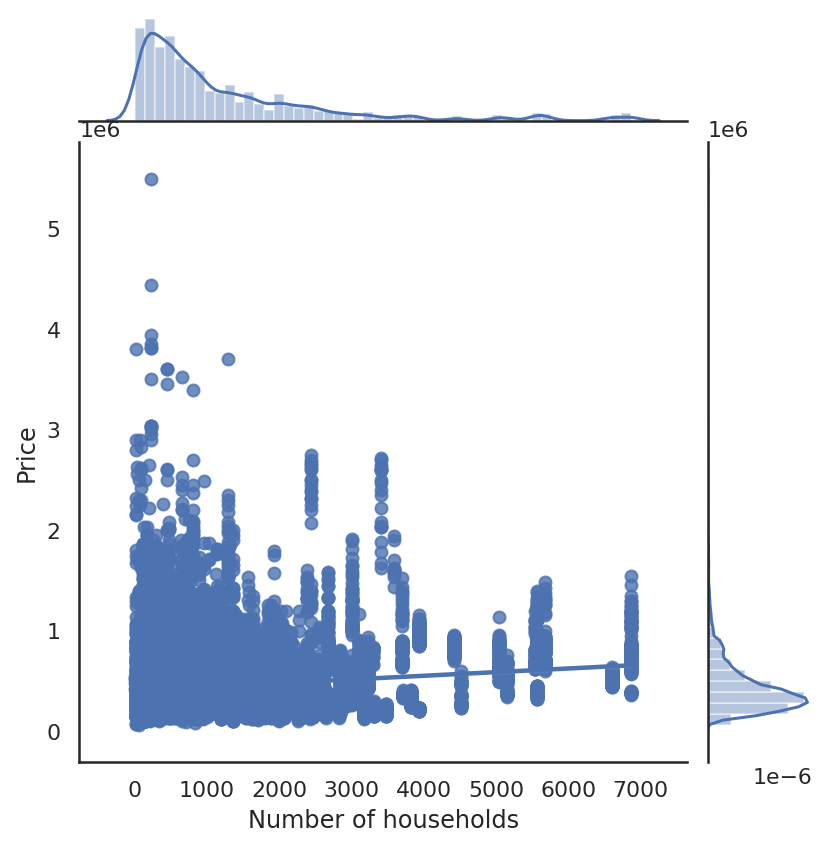

In [21]:
# Number of Households vs Sale Price

fig = sns.jointplot(x=X_train['Hhld'], y= y_train, kind='reg')
fig.ax_joint.set_xlabel('Number of households')
fig.ax_joint.set_ylabel('Price')

Text(23.125, 0.5, 'Price')

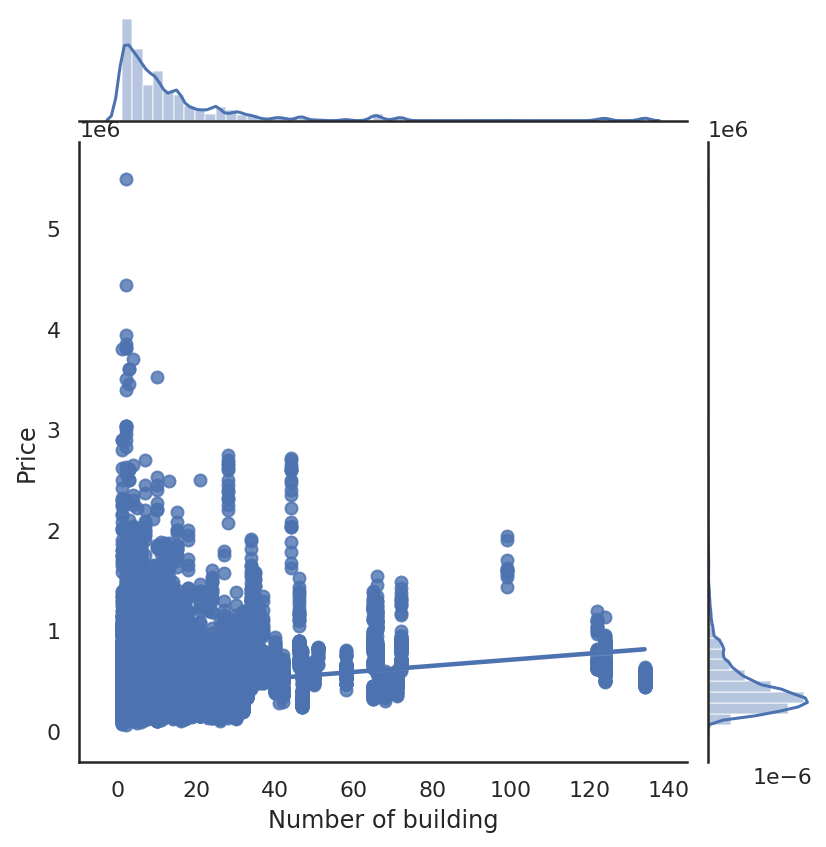

In [22]:
# No building vs Sale Price

fig = sns.jointplot(x=X_train['maxBuild'], y= y_train, kind='reg')
fig.ax_joint.set_xlabel('Number of building')
fig.ax_joint.set_ylabel('Price')

# Models and algorithms used

* For this analysis, we implement those algorithms:

> 1. Random Forests
> 2. XGBoost
> 3. Support vector regression
> 4. k-nearest neighbors
> 5. Multi-layer perceptron

* Note:

> * In order to find the best model, we use the metric of mean absolute errors (MAE). 
> * While using the function GridSearchCV() to find the optimal set of parameters for the algorithms, the Cross Validation score implemented and used is R^2.



# Models and algorithms used

> 1. **LinearRegression**
> * A simple and interpretable baseline model that fits a linear relationship between input features and the target variable.

> 2. **ElasticNet**
> * A regularized linear model that combines both L1 and L2 penalties, useful when handling multicollinearity or when feature selection is beneficial.

> 3. **RandomForestRegressor**
> * A tree-based ensemble model that builds many decision trees and averages their predictions, offering strong performance and robustness to overfitting.

> 4. **GradientBoostingRegressor**
> * A boosting algorithm that sequentially builds decision trees to correct the errors of previous ones, often achieving high accuracy on complex datasets.

> 5. **KNeighborsRegressor**
> * A distance-based model that makes predictions by averaging the target values of the nearest training samples, simple but effective for certain data structures.

Note:

> * In order to find the best model, we use the metric of mean absolute errors (MAE). 
> * While using the function GridSearchCV() to find the optimal set of parameters for the algorithms, the Cross Validation score implemented and used is R^2.



In [23]:
"""
Multi-Model Pipeline with:
- RandomizedSearchCV (coarse search)
- Optional GridSearchCV (fine-tuning)
- Validation set evaluation
"""

# Global random seed for reproducibility
RANDOM_STATE = 42

# --------------------------------------------------
# 1) RandomizedSearchCV: coarse search
# --------------------------------------------------
def randomized_tune(
    estimator,
    param_distributions,
    X,
    y,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_iter=30,
    random_state=RANDOM_STATE,
):
    """
    Run RandomizedSearchCV for a given estimator and parameter distributions.
    This is used as a broad search over the hyperparameter space.
    """
    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        random_state=random_state,
        n_jobs=-1,
        verbose=1,
    )
    search.fit(OH_X_train, y_train)
    return search


In [24]:
# --------------------------------------------------
# 2) Build a fine grid around best params (for GridSearchCV)
#    You can adapt this logic to your own needs.
# --------------------------------------------------
def build_fine_grid(model_name, best_params):
    """
    Build a narrower parameter grid around the best parameters
    found by RandomizedSearchCV.
    
    If no fine grid is defined for a given model, return None.
    """

    if model_name == "ElasticNet":
        alpha = best_params.get("alpha", 0.1)
        l1_ratio = best_params.get("l1_ratio", 0.5)
        alpha_grid = [alpha / 2, alpha, alpha * 2]
        l1_grid = [
            max(0.0, l1_ratio - 0.2),
            l1_ratio,
            min(1.0, l1_ratio + 0.2),
        ]

        return {
            "alpha": alpha_grid,
            "l1_ratio": l1_grid,
        }

    elif model_name == "RandomForest":
        n_estimators = best_params.get("n_estimators", 200)
        max_depth = best_params.get("max_depth", None)
        min_samples_split = best_params.get("min_samples_split", 2)
        min_samples_leaf = best_params.get("min_samples_leaf", 1)
        max_features     = best_params.get("max_features", "sqrt")

        n_est_grid = sorted(
            set([max(50, n_estimators - 100), n_estimators, n_estimators + 100])
        )
        if max_depth is None:
            depth_grid = [None, 5, 10]
        else:
            depth_grid = sorted(
                set([max(2, max_depth - 2), max_depth, max_depth + 2])
            )
        split_grid = sorted(
            set([max(2, min_samples_split - 1), min_samples_split, min_samples_split + 1])
        )
        leaf_grid = sorted(
            set([max(1, min_samples_leaf - 1), min_samples_leaf, min_samples_leaf + 1])
        )
        feature_grid = list({max_features, "sqrt", "log2"})
        
        return {
            "n_estimators": n_est_grid,
            "max_depth": depth_grid,
            "min_samples_split": split_grid,
            "min_samples_leaf": leaf_grid,
            "max_features":  feature_grid    
        }

    
    elif model_name == "GradientBoosting":
        n_estimators = best_params.get("n_estimators", 200)
        learning_rate = best_params.get("learning_rate", 0.1)
        max_depth = best_params.get("max_depth", 3)

        n_est_grid = sorted(
            set([max(50, n_estimators - 50), n_estimators, n_estimators + 50])
        )
        lr_grid = sorted(set([learning_rate / 2, learning_rate, learning_rate * 2]))
        depth_grid = sorted(
            set([max(1, max_depth - 1), max_depth, max_depth + 1])
        )

        return {
            "n_estimators": n_est_grid,
            "learning_rate": lr_grid,
            "max_depth": depth_grid,
        }

    elif model_name == "KNN":
        n_neighbors = best_params.get("n_neighbors", 5)
        weights = best_params.get("weights", "uniform")
        p = best_params.get("p", 2)

        n_grid = sorted(
            set([max(1, n_neighbors - 2), n_neighbors, n_neighbors + 2])
        )

        return {
            "n_neighbors": n_grid,
            "weights": [weights],  # keep the best one fixed
            "p": [p],              # keep the best metric fixed
        }

    # If no fine grid is defined, return None
    return None




In [25]:
# --------------------------------------------------
# 3) Define models and their parameter distributions
# --------------------------------------------------
models = [

    # 1. Linear Regression (baseline model, no tuning)
    {
        "name": "LinearRegression",
        "estimator": LinearRegression(),
        "param_dist": None,
        "use_random_search": False,
        "use_grid_search": False,  # nothing to tune
    },

    # 2. ElasticNet (regularized linear model)
    {
        "name": "ElasticNet",
        "estimator": ElasticNet(random_state=RANDOM_STATE),
        "param_dist": {
            "alpha": np.logspace(-3, 1, 20),
            "l1_ratio": np.linspace(0.0, 1.0, 11),
        },
        "use_random_search": True,
        "use_grid_search": True,
    },

    # 3. Random Forest
    {
        "name": "RandomForest",
        "estimator": RandomForestRegressor(random_state=RANDOM_STATE),
        "param_dist": {
            "n_estimators": [100, 200, 300, 500],
            "max_depth": [3, 5, 7, 10, None],
            "max_features": ["auto", "sqrt", 0.5],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
        "use_random_search": True,
        "use_grid_search": True,
    },

    # 4. Gradient Boosting
    {
        "name": "GradientBoosting",
        "estimator": GradientBoostingRegressor(random_state=RANDOM_STATE),
        "param_dist": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1, 0.2],
            "max_depth": [2, 3, 4],
            "subsample": [0.7, 0.8, 1.0],
        },
        "use_random_search": True,
        "use_grid_search": True,
    },

    # 5. K-Nearest Neighbors
    {
        "name": "KNN",
        "estimator": KNeighborsRegressor(),
        "param_dist": {
            "n_neighbors": [3, 5, 7, 9, 11, 15],
            "weights": ["uniform", "distance"],
            "p": [1, 2],
        },
        "use_random_search": True,
        "use_grid_search": True,
    },
]




In [26]:
# --------------------------------------------------
# 4) Loop over models: RandomizedSearchCV → GridSearchCV → Validation eval
# --------------------------------------------------
results = {}

for cfg in models:
    name = cfg["name"]
    estimator = cfg["estimator"]
    param_dist = cfg["param_dist"]

    print(f"\n===== Model: {name} =====")

    # Case 1: baseline model (no tuning)
    if not cfg["use_random_search"] or param_dist is None:
        print("  No hyperparameter tuning. Fitting baseline model on training data...")
        estimator.fit(OH_X_train, y_train)
        best_est = estimator
        best_score_random = None
        best_score_grid = None
        best_params_random = {}
        best_params_grid = {}

    else:
        # 1) RandomizedSearchCV (coarse search on training data)
        print("  Running RandomizedSearchCV on training data...")
        rand_search = randomized_tune(
            estimator=estimator,
            param_distributions=param_dist,
            X=OH_X_train,
            y=y_train,
            scoring="neg_mean_absolute_error",
            cv=5,
            n_iter=30,
            random_state=RANDOM_STATE,
        )

        best_est_random = rand_search.best_estimator_
        best_score_random = rand_search.best_score_
        best_params_random = rand_search.best_params_

        print("  Best params (RandomizedSearchCV):", best_params_random)
        print("  Best CV score (RandomizedSearchCV, neg MAE):", best_score_random)

        best_est = best_est_random
        best_score_grid = None
        best_params_grid = {}

        # 2) Optional GridSearchCV around best params
        if cfg.get("use_grid_search", False):
            fine_grid = build_fine_grid(name, best_params_random)

            if fine_grid is not None:
                print("  Running GridSearchCV for fine-tuning...")
                # Start from the best params from RandomizedSearch
                base_params = estimator.get_params()
                base_params.update(best_params_random)

                grid_search = GridSearchCV(
                    estimator=estimator.__class__(**base_params),
                    param_grid=fine_grid,
                    scoring="neg_mean_absolute_error",
                    cv=5,
                    n_jobs=-1,
                    verbose=1,
                )
                grid_search.fit(OH_X_train, y_train)

                best_est = grid_search.best_estimator_
                best_score_grid = grid_search.best_score_
                best_params_grid = grid_search.best_params_

                print("  Best params (GridSearchCV):", best_params_grid)
                print("  Best CV score (GridSearchCV, neg MAE):", best_score_grid)
            else:
                print("  No fine grid defined for this model. Skipping GridSearchCV.")

    # 3) Evaluate the final best model on the validation set
    y_pred_valid = best_est.predict(OH_X_valid)
    mae_valid = mean_absolute_error(y_valid, y_pred_valid)
    r2_valid = r2_score(y_valid, y_pred_valid)
    y_pred_test = best_est.predict(OH_X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"  Validation MAE: {mae_valid:.4f}")
    print(f"  Validation R^2: {r2_valid:.4f}")

    # Save all relevant information for this model
    results[name] = {
        "best_estimator": best_est,
        "random_search_score": best_score_random,
        "random_search_params": best_params_random,
        "grid_search_score": best_score_grid,
        "grid_search_params": best_params_grid,
        "valid_mae": mae_valid,
        "valid_r2": r2_valid,
        "test_mae": mae_test
    }





===== Model: LinearRegression =====
  No hyperparameter tuning. Fitting baseline model on training data...
  Validation MAE: 87028.4513
  Validation R^2: 0.7805

===== Model: ElasticNet =====
  Running RandomizedSearchCV on training data...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   26.3s finished


  Best params (RandomizedSearchCV): {'l1_ratio': 0.8, 'alpha': 0.04832930238571752}
  Best CV score (RandomizedSearchCV, neg MAE): -89393.87677879512
  Running GridSearchCV for fine-tuning...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.8s finished


  Best params (GridSearchCV): {'alpha': 0.02416465119285876, 'l1_ratio': 0.6000000000000001}
  Best CV score (GridSearchCV, neg MAE): -89393.87305237121
  Validation MAE: 86216.7223
  Validation R^2: 0.7805

===== Model: RandomForest =====
  Running RandomizedSearchCV on training data...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.9min finished


  Best params (RandomizedSearchCV): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
  Best CV score (RandomizedSearchCV, neg MAE): -28917.13724475448
  Running GridSearchCV for fine-tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  7.5min finished


  Best params (GridSearchCV): {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
  Best CV score (GridSearchCV, neg MAE): -28897.640404983285
  Validation MAE: 29120.0783
  Validation R^2: 0.9595

===== Model: GradientBoosting =====
  Running RandomizedSearchCV on training data...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.5min finished


  Best params (RandomizedSearchCV): {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.2}
  Best CV score (RandomizedSearchCV, neg MAE): -36211.62187960385
  Running GridSearchCV for fine-tuning...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  7.9min finished


  Best params (GridSearchCV): {'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 350}
  Best CV score (GridSearchCV, neg MAE): -30180.521769544313
  Validation MAE: 31322.7699
  Validation R^2: 0.9580

===== Model: KNN =====
  Running RandomizedSearchCV on training data...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   10.2s finished


  Best params (RandomizedSearchCV): {'weights': 'distance', 'p': 1, 'n_neighbors': 5}
  Best CV score (RandomizedSearchCV, neg MAE): -31083.21828371596
  Running GridSearchCV for fine-tuning...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.3s finished


  Best params (GridSearchCV): {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
  Best CV score (GridSearchCV, neg MAE): -31083.21828371596
  Validation MAE: 30010.4289
  Validation R^2: 0.9545


# Summary
> * The summary of MAE values obtained from the differnet algorithm is as follows.
> * We mainly use MAE as the primary evaluation metric and additionally report R² as a measure of explained variance. The final model was selected based on the lowest MAE, while ensuring that R² remained reasonably high and stable across validation folds

In [27]:
# --------------------------------------------------
# 5) Final summary: compare models on validation set
# --------------------------------------------------
print("\n===== Final Validation Summary (sorted by MAE) =====")

summary = []
for name, info in results.items():
    summary.append((name, info["valid_mae"], info["valid_r2"], info["test_mae"]))

# Sort by MAE (ascending: lower is better)
summary_sorted = sorted(summary, key=lambda x: x[1])





===== Final Validation Summary (sorted by MAE) =====


In [28]:
summary_sorted

[('RandomForest', 29120.078253301755, 0.9595473350001299, 52184.212448668375),
 ('KNN', 30010.42886930295, 0.9545333534041696, 45147.68675911708),
 ('GradientBoosting',
  31322.76985082996,
  0.9579839325613658,
  63916.129972427734),
 ('ElasticNet', 86216.72233581002, 0.7804610277733861, 92654.6992700948),
 ('LinearRegression', 87028.4513111874, 0.7805437812625659, 92344.03158776299)]

In [29]:
for name, mae, r2, test_mae in summary_sorted:
    print(f"Model: {name:20s} | MAE: {mae:.4f} | R^2: {r2:.4f} | Test_MAE: {test_mae: .4f}")


# select the best model 
best_by_mae = min(summary_sorted, key=lambda x: x[1])

print(f"MAE:{best_by_mae[3]:.4f}")


Model: RandomForest         | MAE: 29120.0783 | R^2: 0.9595 | Test_MAE:  52184.2124
Model: KNN                  | MAE: 30010.4289 | R^2: 0.9545 | Test_MAE:  45147.6868
Model: GradientBoosting     | MAE: 31322.7699 | R^2: 0.9580 | Test_MAE:  63916.1300
Model: ElasticNet           | MAE: 86216.7223 | R^2: 0.7805 | Test_MAE:  92654.6993
Model: LinearRegression     | MAE: 87028.4513 | R^2: 0.7805 | Test_MAE:  92344.0316
MAE:52184.2124


* Conclusion: We found that the `RadomForest` gives the best prediction result.

# Pipeline (Random Forest Model)

* We construct a pipeline for predicting the ATP prices in Seoul. For this analysis, we do not add additional features tha cannot be implemented using the preprocessing functions.

* For more details on Pipelines and its advantages, see [this note.](https://www.kaggle.com/dansbecker/pipelines)


In [30]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data using "Pipeline"
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Bundle preprocessing for numerical and categorical data using "ColumnTransformer"
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



# Define model (optmal model + optimal parameter)
model = RandomForestRegressor(n_estimators=100, random_state=42)


# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])


# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)


# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))


# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test)


# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)



MAE: 27854.94377648001
